In [1]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import roc_auc_score  # or accuracy_score for classification
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib as plt
from scipy.stats import pearsonr

In [2]:
train_df = pd.read_parquet("../data/train_clean_v2.parquet")
test_df = pd.read_parquet("../data/test_clean_v2.parquet")
test_df = test_df.reset_index()

In [3]:
TARGET_COL = "label"

X = train_df.drop(columns=[TARGET_COL])
y = train_df[TARGET_COL]

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [5]:
def pearson_corr_metric(preds, data):
    y_true = data.get_label()
    return 'pearson', np.corrcoef(y_true, preds)[0, 1], True

In [6]:
dtrain = lgb.Dataset(X_train, label=y_train)
dval = lgb.Dataset(X_val, label=y_val)

params = {
    "objective": "regression",
    "metric": "rmse",
    "device": "gpu",
    "gpu_platform_id": 0,
    "gpu_device_id": 0,
    "verbosity": 1
}

model = lgb.train(
    params,
    dtrain,
    num_boost_round=4000,
    valid_sets=[dval],
    valid_names=["val"],
    feval=pearson_corr_metric,  # custom Pearson metric
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=100)
    ]
)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 221319
[LightGBM] [Info] Number of data points in the train set: 420709, number of used features: 868
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 5070 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 795 dense feature groups (319.37 MB) transferred to GPU in 0.047466 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.037167
Training until validation scores don't improve for 50 rounds
[100]	val's rmse: 0.673694	val's pearson: 0.805298
[200]	val's rmse: 0.549965	val's pearson: 0.874221
[300]	val's rmse: 0.472121	val's pearson: 0.907877
[400]	val's rmse: 0.41516	val's pearson: 0.928601
[500]	val's rmse: 0.373854	val's pearson: 0.941492
[600]	val's rmse: 0.341903	val's p

In [7]:
# Predict and evaluate
y_pred = model.predict(X_val)

# Compute Pearson correlation
pearson_corr, _ = pearsonr(y_val, y_pred)
print(f"Pearson correlation: {pearson_corr:.4f}")

Pearson correlation: 0.9892


In [8]:
test_df

,index,ID,bid_qty,ask_qty,buy_qty,sell_qty,volume,X1,X2,X3,...,X882,X883,X884,X885,X886,X887,X888,X889,X890,label
0,0,1,0.114,12.121,10.587000,10.971000,21.558001,-0.732818,0.512331,-0.041982,...,1.014336,1.367567,1.584126,1.584126,1.584126,1.584125,1.567979,1.426368,2.192682,0.0
1,1,2,2.426,2.962,136.240997,12.304000,148.544998,-0.337995,-0.412176,-0.259468,...,1.748939,1.848177,0.000131,0.000323,0.001746,0.007319,0.050925,0.142206,0.739759,0.0
2,2,3,1.085,2.343,23.389999,57.171001,80.560997,0.111249,0.458221,0.466916,...,1.704680,1.772028,0.000550,0.003597,0.009265,0.019948,0.072535,0.169672,0.807862,0.0
3,3,4,14.793,1.117,116.517998,13.082000,129.600006,-0.149399,-0.640638,-0.873778,...,0.930946,1.037839,1.382037,1.382037,1.382037,1.382037,1.381752,1.363445,2.465509,0.0
4,4,5,0.033,14.178,43.799999,49.835999,93.636002,-0.694662,0.611254,0.067671,...,1.080267,1.141878,0.000363,0.012718,0.137533,0.464112,1.050577,1.268567,2.499015,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538145,538145,538146,8.599,2.327,74.570000,42.691002,117.261002,0.198687,0.135445,0.505441,...,2.185495,2.257754,1.239053,0.646543,0.368060,0.196958,0.074014,0.059849,0.245092,0.0
538146,538146,538147,5.027,7.296,45.056999,19.150999,64.208000,-0.451693,-0.433553,-0.232846,...,1.776626,1.724998,0.000021,0.000027,0.000029,0.000083,0.049487,0.274900,1.162933,0.0
538147,538147,538148,12.780,1.054,23.926001,38.283001,62.209000,0.574457,0.482240,1.076440,...,1.340804,1.420642,0.000600,0.005740,0.089671,0.374153,0.977561,1.223688,2.454477,0.0
538148,538148,538149,4.317,1.407,51.467999,111.705002,163.173004,-0.560855,-0.324104,-0.356042,...,2.742464,3.034341,0.000089,0.000102,0.000153,0.000627,0.021699,0.044349,0.180866,0.0


In [ ]:
test_preds = model.predict(test_df.drop(columns=["ID", "label", "index"]))

submission = pd.DataFrame({
    "ID": test_df["ID"],
    "prediction": test_preds
})

submission.to_csv("../data/lightgbm_test_preds.csv", index=False)


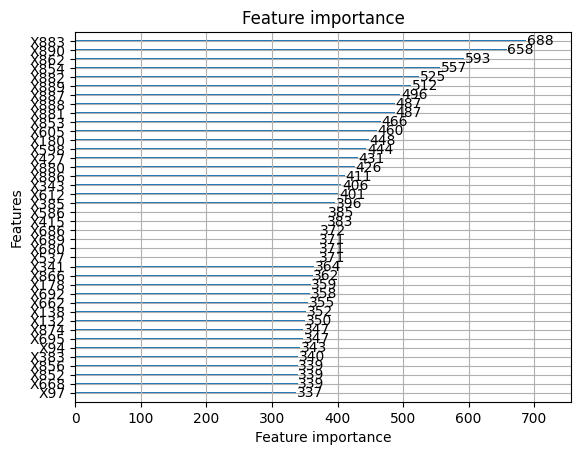

In [10]:
import matplotlib.pyplot as plt

lgb.plot_importance(model, max_num_features=40)
plt.show()

In [11]:
importance_df = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance(importance_type='gain')  # or 'split'
})

# Sort by importance
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
importance_df.to_csv("../data/lgbm_feature_importance.csv", index=False)
# Display or print top N
print(importance_df.head(40))  # or convert to list


   feature    importance
0     X785  35758.181562
1     X862  33171.062188
2     X466  26573.085168
3     X853  26056.488024
4     X883  23488.630344
5     X854  23329.111789
6     X890  22523.415041
7     X888  21134.359289
8     X889  20886.989193
9     X284  20616.695084
10    X344  17826.674186
11    X537  16830.484818
12    X180  16667.178207
13    X873  16409.337824
14    X425  15442.601636
15     X96  15234.763848
16    X887  15047.252207
17    X385  14909.159539
18    X427  14905.290379
19    X695  14835.823742
20    X605  14311.527604
21    X696  13827.301287
22    X689  13490.774345
23    X343  13452.984052
24    X341  13242.979242
25    X421  13023.581863
26    X882  12963.486871
27    X598  12907.740892
28    X852  12815.818709
29    X383  12557.387965
30    X786  12348.536088
31    X132  12208.384303
32    X612  11793.009220
33    X530  11668.060829
34    X686  11601.453371
35    X692  11435.509121
36     X97  11399.834861
37    X886  11380.651096
38    X181  11214.062455


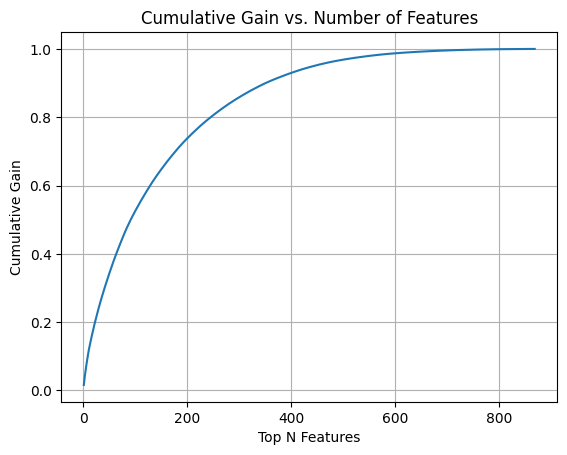

In [12]:
cumulative_gain = np.cumsum(importance_df["importance"]) / importance_df["importance"].sum()

plt.plot(range(1, len(cumulative_gain)+1), cumulative_gain)
plt.xlabel("Top N Features")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain vs. Number of Features")
plt.grid(True)
plt.show()
